In [40]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

eradir = Path(os.path.expanduser('~/ERA5/'))                                                                  

In [2]:
#da = xr.open_dataarray(eradir / 'olr_tropics.nc')
#da = xr.open_dataset(eradir / 'sst_nhplus.nc', group = 'mean')['sst-mean']
da = xr.open_dataarray(eradir / 'sst_nhplus.nc')

regions = pd.DataFrame({'latrange':[slice(-1.5,5.5),slice(10.75,15.25),slice(19.5,24.25)],
    'lonrange':[slice(162,169),slice(147,151.75),slice(155,161)]},
    index = pd.Index(['warm1','cold1','cold2']), dtype = 'object')

def selectregion(array: xr.DataArray, name: str):
    assert (name in regions.index), f'choose one of the region names in {regions.index}'
    return array.sel(latitude = regions.loc[name,'latrange'], longitude = regions.loc[name,'lonrange'])

def spatial_mean(array: xr.DataArray):
    stacked = array.stack({'latlon':['latitude','longitude']})
    return stacked.mean('latlon')

def annual_mean(array: xr.DataArray):
    return array.groupby(array.time.dt.year).mean()

In [3]:
warm = selectregion(da,'warm1')
cold1 = selectregion(da,'cold1')
cold2 = selectregion(da,'cold2')

### Visualization of chosen regions

In [15]:
corrpattern = xr.open_dataset('/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)

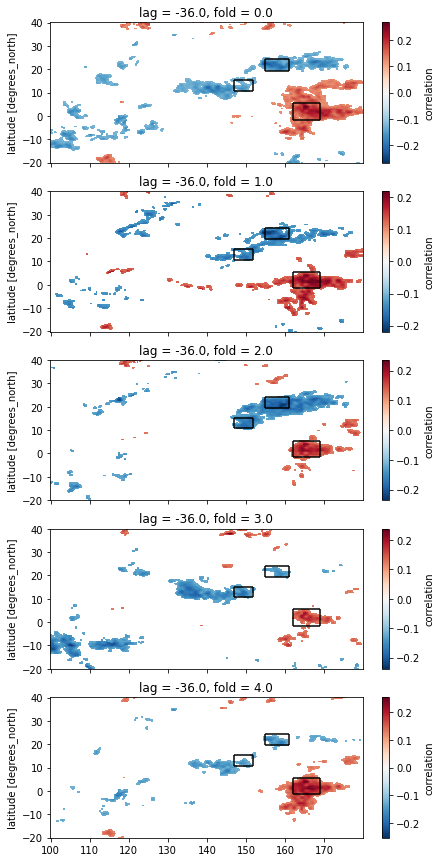

In [56]:
fig, axes = plt.subplots(nrows = 5, figsize = (7,15), sharex = True)
for i in corrpattern.coords['fold']:
    ax = axes[int(i)]
    field = corrpattern['correlation'].sel(fold = i, lag = -36)
    field.sel(latitude = slice(-20,40), longitude = slice(100,180)).plot(ax = ax)
    ax.set_xlabel('')
    for region in regions.index:
        coords = regions.loc[region,:]
        ax.hlines(y = coords['latrange'].start, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.hlines(y = coords['latrange'].stop, xmin = coords['lonrange'].start, xmax = coords['lonrange'].stop)
        ax.vlines(x = coords['lonrange'].start, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)
        ax.vlines(x = coords['lonrange'].stop, ymin = coords['latrange'].start, ymax = coords['latrange'].stop)

### Time aggregation, Detrending, de-seasonalizing Functions

In [4]:
def agg_time(array: xr.DataArray, ndayagg: int = 1, method: str = 'mean') -> xr.DataArray:
    """
    Aggegates a daily time dimension by rolling averaging,
    Time axis should be continuous, otherwise non-neighbouring values are taken together. 
    It returns a left stamped aggregation of ndays
    Trailing Nan's are removed.
    """
    assert (np.diff(array.time) == np.timedelta64(1,'D')).all(), "time axis should be a continuous daily to be aggregated, though nan is allowed"

    name = array.name
    attrs = array.attrs
    f = getattr(array.rolling({'time':ndayagg}, center = False), method) # Stamped right
    array = f()
    array = array.assign_coords(time = array.time - pd.Timedelta(str(ndayagg - 1) + 'D')).isel(time = slice(ndayagg - 1, None)) # Left stamping, trailing nans removed
    array.name = name
    array.attrs = attrs
    return array

def fit_poly(array, degree: int = 3, year: int = None) -> xr.DataArray:
    """
    Fit 3rd order seasonal polynomial for each gridpoint in this data. 
    X is day of the year.
    Possibly for a single year, otherwise all years are joined
    If fitted per year discontinuities around winter are more likely.
    returns array of coefficients.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = array.stack({'latlon':['latitude','longitude']})
    coefs = np.polynomial.polynomial.polyfit(x = X, y = y, deg = degree)
    coefs = xr.DataArray(coefs, dims = ('coefs','latlon'), coords = y.coords['latlon'].coords)
    coefs = coefs.assign_coords({'coefs':np.arange(degree+1)})
    return coefs.unstack('latlon')

def evaluate_poly(array : xr.DataArray, coefs: xr.DataArray, year: int = None):
    """
    Evaluates the polynomial on the first time dimension. np.Polyval cannot do this for all gridcells at once
    So custom computation.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = xr.DataArray(np.zeros(array.shape), coords = array.coords, dims = array.dims)
    for degree in range(len(coefs)): # possibly later: https://en.wikipedia.org/wiki/Horner%27s_method
        y += X**degree * coefs.sel(coefs = degree, drop = True)
    return y

def deseasonalize(array: xr.DataArray, per_year: bool = False, return_polyval: bool = False, degree = 3):
    """
    If per year then trend is removed (and likely also interannual variability)
    plus you'll get a jump on the first of january. (not so important for summer)
    """
    deseasonalized = array.copy()
    deseasonalized.name = f'{deseasonalized.name}-anom'
    if per_year:
        years = np.unique(array.time.dt.year)
        if return_polyval:
            polyval = array.copy()
        for year in years:
            yearly_polyval = evaluate_poly(array, coefs = fit_poly(array, year = year, degree = degree), year = year)
            deseasonalized.loc[deseasonalized.time.dt.year == year,...] = deseasonalized.loc[deseasonalized.time.dt.year == year,...] - yearly_polyval
            if return_polyval:
                polyval.loc[polyval.time.dt.year == year,...] = yearly_polyval
    else:
        polyval = evaluate_poly(array, coefs = fit_poly(array, degree = degree))
        deseasonalized -= polyval
    if return_polyval:
        return deseasonalized, polyval
    else:
        return deseasonalized

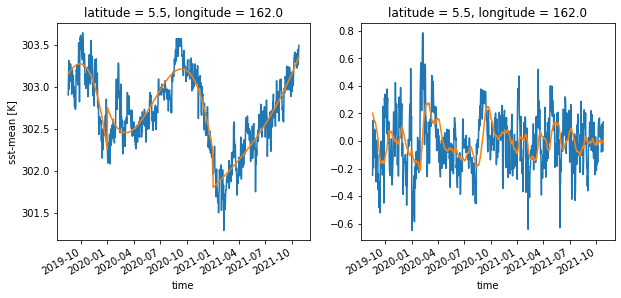

In [41]:
start = -800
latidx = -1
lonidx = 0
detrended, polyval = deseasonalize(warm,per_year=True, return_polyval=True)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}).mean()[start:].plot(ax = axes[1])

Per year removes interannual variability (rolling 3000 would result in nonesense). Trend is also removed. Intra-annual peaks are however still present, same timing as per_year=False

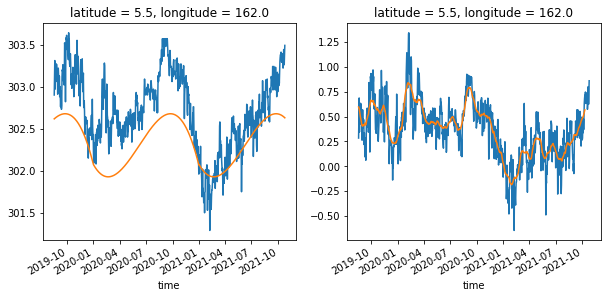

In [48]:
detrended, polyval = deseasonalize(warm,per_year=False, return_polyval=True, degree = 3)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}, center = True).mean()[start:].plot(ax = axes[1])

### Versions of the sst index, and properties

In [5]:
# Aggregation of time?
def makeindex(deseason = True, remove_interannual = True, timeagg: int = None):
    """ 
    Whether to deseason on the daily timescale and per gridpoint
    Remove interannual only relevant if deasonalizing
    Aggregation by time possible before constructing the index (left stamping)
    """
    components = {'w':warm.copy(),'c1':cold1.copy(),'c2':cold2.copy()}
    if deseason:
        for key,field in components.items():
            components[key] = deseasonalize(field,per_year=remove_interannual, return_polyval=False, degree = 3)
    if not (timeagg is None):
        for key,field in components.items():
            components[key] = agg_time(array = field, ndayagg = timeagg)
    index = spatial_mean(components['w']) - np.stack([spatial_mean(components['c1']),spatial_mean(components['c2'])]).min(axis = 0)
    return index

In [6]:
index = makeindex(deseason=False, remove_interannual=False)
index2 = makeindex(deseason = True, remove_interannual=False)
index3 = makeindex(deseason = True, remove_interannual=False, timeagg = 21)
index4 = makeindex(deseason = True, remove_interannual=True)
indices = {'1d_seas_inter':index, 
           '1d_deseas_inter':index2, 
           '21d_deseas_inter':index3, 
           '1d_deseas_deinter':index4, 
          }

Annual means not always meaningful. Big seasonal differences.

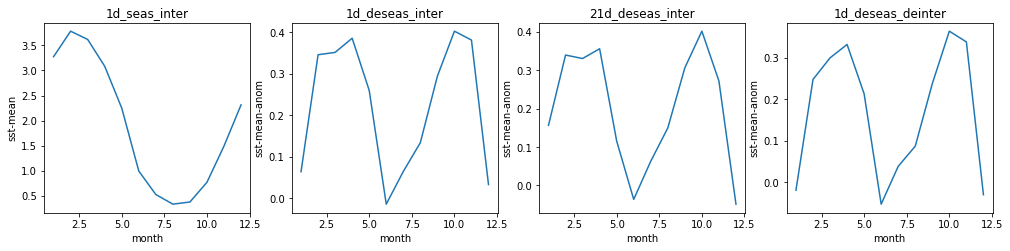

In [77]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.groupby(idx.time.dt.month).mean().plot(ax = ax)
    ax.set_title(key)

Trends are not very present even though the patches themselves still have mean warming (if not deseasonalized per year).

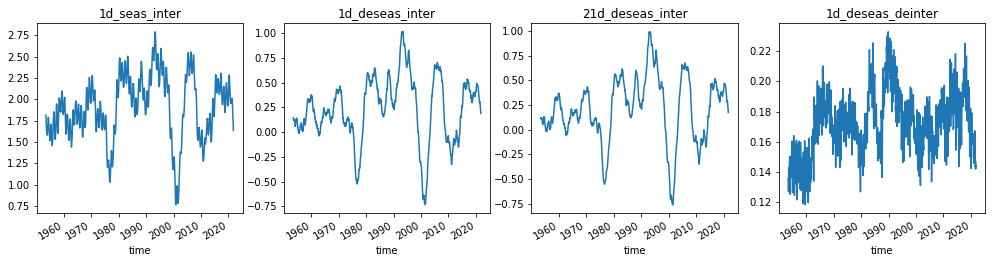

In [78]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (17,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    idx.rolling({'time':1200}).mean().plot(ax = ax)
    ax.set_title(key)

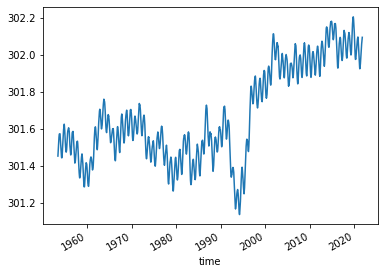

In [85]:
# here the warming trend in one of the patches. You also see seasonality in the patches of the equator (cold1 and cold2).
spatial_mean(cold1).rolling({'time':1200}).mean().plot()

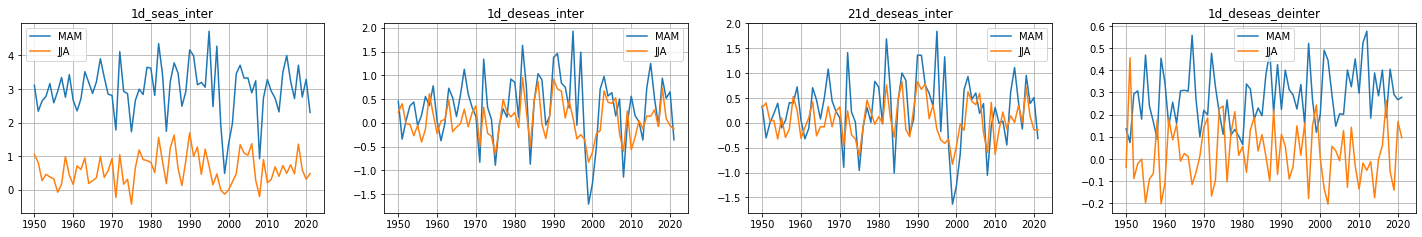

In [7]:
fig, axes = plt.subplots(ncols = len(indices), figsize = (25,3.5))

for i, (key,idx) in enumerate(indices.items()):
    ax = axes[i]
    for season in ['MAM','JJA']:
        s = idx[idx.time.dt.season == season]
        s_yearly = s.groupby(s.time.dt.year).mean()
        ax.plot(s_yearly.year, s_yearly.values, label = season)
    ax.set_title(key)
    ax.legend()
    ax.grid(True)

Remarkable that in the latter case an anti-correlation seens to have formed. Other variables have anti-correlation only in the beginning of the timeseries. 
Also 21-day version (before index construction) is not dissimilar from the 1day version, in this seasonally aggregated vision.

#### Correspondence to ENSO index? Correspondence to covariance timeseries.

In [51]:
sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.models import map_foldindex_to_groupedorder

filepath = '/scistor/ivm/jsn295/paper2/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
df = pd.read_parquet(filepath)
df = df.sort_index(axis =1)
# We must read fold 4, because this is the only one not using a large part of our data for training.
#order = map_foldindex_to_groupedorder(df, n_folds = 5) # strictly speaking fold 4 will remain fold 4

In [60]:
# These are pre-lagged
timeagg = 21
lag = -15
ssts = df.loc[:,(4,'sst_nhplus',timeagg,slice(None),lag,4,'spatcov')]

In [61]:
ssts_unlagged = ssts.copy().dropna()
ssts_unlagged.index = ssts_unlagged.index - pd.Timedelta(timeagg + abs(lag), unit ='D')

In [62]:
correlations = pd.DataFrame(np.nan, index = indices.keys(), columns = ['pearson','spearman'])
for key,idx in indices.items():
    subset = idx.to_pandas().loc[ssts_unlagged.index]
    correlations.loc[key,'pearson'] = pearsonr(subset.values,ssts_unlagged.values.squeeze())[0]
    correlations.loc[key,'spearman'] = spearmanr(subset.values,ssts_unlagged.values.squeeze())[0]

In [63]:
correlations

,pearson,spearman
1d_seas_inter,0.504876,0.503117
1d_deseas_inter,0.846384,0.823068
21d_deseas_inter,0.908387,0.897322
1d_deseas_deinter,0.152097,0.156678


This is good news. Apparently versions of the index corresponds well to the spatial covariance (in the 1981-2019 period at least). Interannual variability should not be removed. That much is clear.

TODO: Would be interesting to find out if the min or the mean version corresponds better

## Creation of temperature target

In [64]:
subdomainlats = slice(40,56)
subdomainlons = slice(-5,24)
t2m = xr.open_dataarray(eradir / 't2m_europe.nc').sel(latitude = subdomainlats, longitude = subdomainlons)
clusterfield = xr.open_dataarray('/scistor/ivm/jsn295/clusters/t2m-q095.nc').sel(nclusters = 15, latitude = subdomainlats, longitude = subdomainlons)

In [65]:
t2manom, polyval = deseasonalize(t2m,per_year=False, return_polyval=True, degree = 3)

In [66]:
t2manom

<xarray.DataArray 't2m-mean-anom' (time: 26172, latitude: 65, longitude: 117)>
array([[[-0.20360255, -0.92807484, -1.1328996 , ...,  1.0647577 ,
          1.3630434 ,  1.3202391 ],
        [-0.9604372 , -0.85665566, -1.0053082 , ...,  1.2504207 ,
          1.4702294 ,  1.435042  ],
        [-1.5329207 , -1.3468527 , -1.6966829 , ...,  0.89150685,
          1.0951548 ,  1.1419183 ],
        ...,
        [ 0.09938548, -0.1106277 , -0.3250267 , ..., -4.150986  ,
         -3.8694189 , -3.5914886 ],
        [-0.11624435, -0.43802738, -0.54638463, ..., -3.667518  ,
         -3.4564009 , -3.2141092 ],
        [-0.5508307 , -0.7488254 , -0.81076974, ..., -3.2267616 ,
         -3.0339007 , -2.884821  ]],

       [[-1.517682  , -2.1852002 , -2.8710856 , ...,  1.3007853 ,
          1.3398674 ,  1.3599946 ],
        [-2.090606  , -2.672566  , -3.1035893 , ...,  0.8969279 ,
          1.1927235 ,  1.2063159 ],
        [-2.835484  , -3.3942957 , -3.6876988 , ...,  0.8153715 ,
          1.1370109 ,  1.0339973 ],
        ...,
        [ 2.1637936 ,  2.305697  ,  2.6408408 , ..., -2.6885214 ,
         -2.6885622 , -2.6922617 ],
        [ 2.514961  ,  2.7022681 ,  2.8502367 , ..., -2.7032037 ,
         -2.6334252 , -2.5924847 ],
        [ 2.8068004 ,  2.9624674 ,  2.862054  , ..., -2.6415746 ,
         -2.589918  , -2.5619528 ]],

       [[-2.7720234 , -3.2626433 , -3.5295432 , ..., -0.4637849 ,
         -0.503893  , -0.40084174],
        [-1.4810838 , -2.2287953 , -2.68212   , ..., -0.8967838 ,
         -0.78503007, -0.84296614],
        [-0.37837586, -1.2820557 , -2.0590475 , ..., -0.84082705,
         -0.7411825 , -0.9542837 ],
        ...,
        [ 1.9676476 ,  2.081582  ,  2.2663918 , ..., -1.5857157 ,
         -1.6073025 , -1.6326311 ],
        [ 2.125774  ,  2.2623053 ,  2.466625  , ..., -1.5385478 ,
         -1.5100919 , -1.510517  ],
        [ 2.2641892 ,  2.5536108 ,  2.6547236 , ..., -1.8360505 ,
         -1.8056229 , -1.7587172 ]],

       ...,

       [[-3.9329324 , -3.9538248 , -3.9694505 , ..., -1.6810657 ,
         -1.8252358 , -2.1921346 ],
        [-4.285093  , -4.3488493 , -4.360367  , ..., -1.9779115 ,
         -2.53476   , -2.639704  ],
        [-4.33333   , -4.370478  , -4.7135878 , ..., -2.4278665 ,
         -3.0325468 , -3.006944  ],
        ...,
        [ 0.67183167,  0.7140682 ,  0.7551889 , ..., -3.464265  ,
         -3.3758678 , -3.2731032 ],
        [ 0.83580947,  0.8668042 ,  0.8556574 , ..., -3.7189994 ,
         -3.6130888 , -3.5060241 ],
        [ 0.7920672 ,  0.7566452 ,  0.6579906 , ..., -3.6419134 ,
         -3.562611  , -3.5165045 ]],

       [[-4.308858  , -4.2457037 , -4.561178  , ..., -2.935022  ,
         -3.1997008 , -3.329342  ],
        [-3.8059475 , -3.8423812 , -4.1321187 , ..., -3.4884021 ,
         -3.9399524 , -3.4684205 ],
        [-3.3438876 , -3.4145417 , -3.3323057 , ..., -3.857617  ,
         -4.2779074 , -3.777773  ],
        ...,
        [ 1.2773855 ,  1.4865074 ,  1.9359174 , ..., -4.733861  ,
         -4.8044286 , -4.86063   ],
        [ 1.8119777 ,  2.2320216 ,  2.3843596 , ..., -4.569565  ,
         -4.622503  , -4.674323  ],
        [ 2.2591066 ,  2.469443  ,  2.4300535 , ..., -4.452732  ,
         -4.4923763 , -4.5253186 ]],

       [[-4.26211   , -3.9548855 , -3.9502258 , ..., -5.266636  ,
         -5.4718323 , -5.4842005 ],
        [-3.5841875 , -3.7131834 , -3.7211678 , ..., -5.596411  ,
         -5.7626033 , -5.4547153 ],
        [-2.7319636 , -2.9160628 , -3.2284048 , ..., -5.564712  ,
         -5.8405457 , -5.5260053 ],
        ...,
        [-0.715657  , -0.69956636, -0.74186885, ..., -3.541034  ,
         -3.5705845 , -3.6057584 ],
        [-0.6704056 , -0.6012663 , -0.6854445 , ..., -3.2777116 ,
         -3.3294835 , -3.3801756 ],
        [-0.65236765, -0.63623637, -0.69637173, ..., -3.0810778 ,
         -3.139685  , -3.1916716 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1950-03-01 1950-03-02 ... 2021-10-25
  * latitude   (latitude) float32 40.0 40.25

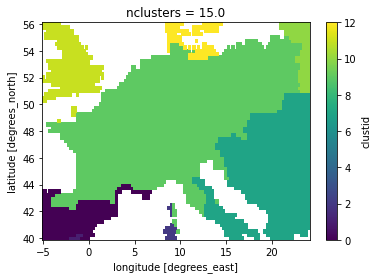

In [70]:
clusterfield.plot()

In [67]:
reduced = t2manom.groupby(clusterfield).mean('stacked_latitude_longitude')
reduced = reduced.sel(clustid = 9)

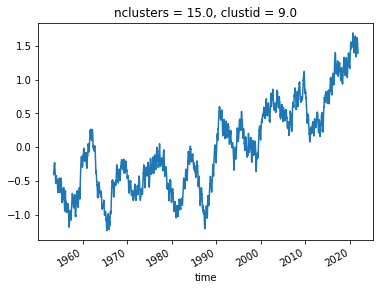

In [70]:
reduced.rolling({'time':1200}).mean().plot()